# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as ns
import matplotlib.pyplot as plt
import requests
import os
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
import string
from wordcloud import WordCloud

In [2]:
# Ignoring warnings
import warnings
warnings.filterwarnings("ignore")

# Data Extraction

In [3]:
df = pd.read_excel('input.xlsx')

error_urls = []

articles_folder = 'Articles'
os.makedirs(articles_folder, exist_ok=True)

for index, row in df.iterrows():
    
    url_id = row['URL_ID']
    url = row['URL']
    
    url_id = int(url_id) if url_id.is_integer() else url_id
    
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise an HTTPError

        html_content = response.text
        soup = BeautifulSoup(html_content, 'html.parser')

        article_title = soup.title.text.strip()

        # Extract article text within <div class="td-post-content tagdiv-type"> in the body
        div_content = soup.body.find('div', class_='td-post-content tagdiv-type')
        if div_content:
            
            # Exclude <pre class="wp-block-preformatted"> from the text
            for pre in div_content.find_all('pre', class_='wp-block-preformatted'):
                pre.decompose()

            article_text = div_content.get_text(strip=True)
            
            # Save
            article_file_path = os.path.join(articles_folder, f'{url_id}.txt')
            with open(article_file_path, 'w', encoding='utf-8') as article_file:
                article_file.write(f'{article_title}\n\n')
                article_file.write(article_text)
                
        else:
            print(f"Error: No <div class='td-post-content tagdiv-type'> found in {url_id}")
            error_urls.append(url_id)

    except requests.exceptions.RequestException as e:
        print(f"\033[1mError for {url_id}: {e}\033[0m")

Error: No <div class='td-post-content tagdiv-type'> found in 2345
Error: No <div class='td-post-content tagdiv-type'> found in 4279.2
Error: No <div class='td-post-content tagdiv-type'> found in 8435.4
Error for 11668: 404 Client Error: Not Found for url: https://insights.blackcoffer.com/how-neural-networks-can-be-applied-in-various-areas-in-the-future/
Error: No <div class='td-post-content tagdiv-type'> found in 14900.6
Error for 17671.4: 404 Client Error: Not Found for url: https://insights.blackcoffer.com/covid-19-environmental-impact-for-the-future/
Error: No <div class='td-post-content tagdiv-type'> found in 33372.6
Error: No <div class='td-post-content tagdiv-type'> found in 33834.4
Error: No <div class='td-post-content tagdiv-type'> found in 37528.8
Error: No <div class='td-post-content tagdiv-type'> found in 40761.4
Error: No <div class='td-post-content tagdiv-type'> found in 41223.2
Error: No <div class='td-post-content tagdiv-type'> found in 43070.4


In [4]:
for url_id in error_urls:
    
    row = df[df['URL_ID'] == url_id].iloc[0]
    url = row['URL']

    try:
        response = requests.get(url)
        response.raise_for_status()
        
        html_content = response.text

        soup = BeautifulSoup(html_content, 'html.parser')

        article_title = soup.title.text.strip()

        # Find all occurrences of <div class="tdb-block-inner td-fix-index">
        div_tags = soup.find_all('div', class_='tdb-block-inner td-fix-index')

        # Check if at least 15 occurrences are present
        if len(div_tags) >= 15:
            div_content = div_tags[14]

            # Exclude <pre class="wp-block-preformatted"> from the text
            for pre in div_content.find_all('pre', class_='wp-block-preformatted'):
                pre.decompose()

            article_text = div_content.get_text(strip=True)

            # Save
            article_file_path = os.path.join(articles_folder, f'{url_id}.txt')
            with open(article_file_path, 'w', encoding='utf-8') as article_file:
                article_file.write(f'{article_title}\n\n')
                article_file.write(article_text)
                
        else:
            print(f"Error: Less than 15 occurrences of <div class='tdb-block-inner td-fix-index'> found in {url_id}")

    except requests.exceptions.RequestException as e:
        print(f"Error for {url_id}: {e}")

# Initializing stopwords, positive words and negative words lists

In [5]:
stop_words_directory = 'StopWords' 
stop_words = set()

# Read the list of stop words text file names in the directory
stop_words_file_names = os.listdir(stop_words_directory)

# Read and combine stop words from each file
for stop_words_file_name in stop_words_file_names:
    if stop_words_file_name.endswith('.txt'):
        with open(os.path.join(stop_words_directory, stop_words_file_name), 'r', encoding='latin-1') as file:
            stop_words.update(file.read().splitlines())

# Load positive and negative words
positive_words_path = 'MasterDictionary/positive-words.txt'
negative_words_path = 'MasterDictionary/negative-words.txt'
positive_words = set()
negative_words = set()

# Read positive words
with open(positive_words_path, 'r', encoding='latin-1') as positive_words_file:
    positive_words.update(positive_words_file.read().splitlines())

# Read negative words
with open(negative_words_path, 'r', encoding='latin-1') as negative_words_file:
    negative_words.update(negative_words_file.read().splitlines())

# Defining functions to calculate variables

In [6]:
def clean_text(text):

    text = text.lower()
    tokens = nltk.word_tokenize(text)

    # Remove stop words
    tokens = [word for word in tokens if word not in stop_words]

    # Remove punctuation
    tokens = [word for word in tokens if word not in string.punctuation]

    cleaned_text = ' '.join(tokens)

    return cleaned_text

In [7]:
def calculate_scores(tokens):
    
    positive_score = sum(1 for word in tokens if word in positive_words)
    negative_score = sum(1 for word in tokens if word in negative_words)

    # Polarity Score
    polarity_score = (positive_score - negative_score) / ((positive_score + negative_score) + 0.000001)
    # Ensure the polarity score is within the range of -1 to 1
    polarity_score = max(min(polarity_score, 1.0), -1.0)

    # Subjectivity Score
    total_words_after_cleaning = len(tokens)
    subjectivity_score = (positive_score + negative_score) / (total_words_after_cleaning + 0.000001)
    # Ensure the subjectivity score is within the range of 0 to 1
    subjectivity_score = max(min(subjectivity_score, 1.0), 0.0)


    return positive_score, negative_score, polarity_score, subjectivity_score

def avg_sentence_length(tokens):
    
    sentences = nltk.sent_tokenize(' '.join(tokens))
    return sum(len(nltk.word_tokenize(sentence)) for sentence in sentences) / len(sentences)

def calculate_percentage_complex_words(tokens):
    
    complex_words = [word for word in tokens if syllable_count(word) > 2]
    return (len(complex_words) / len(tokens)) * 100 if tokens else 0


def fog_index(avg_sentence_length, percentage_complex_words):
    
    return 0.4 * (avg_sentence_length + percentage_complex_words)

def avg_words_per_sentence(tokens):
    
    sentences = nltk.sent_tokenize(' '.join(tokens))
    return len(tokens) / len(sentences) if len(sentences) > 0 else 0

def complex_word_count(tokens):
    
    return sum(1 for word in tokens if syllable_count(word) > 2)

def word_count(tokens):
    
    return len(tokens)

def syllable_per_word(tokens):
    
    total_syllables = sum(syllable_count(word) for word in tokens)
    return total_syllables / len(tokens) if len(tokens) > 0 else 0

def personal_pronouns_count(tokens):
    
    personal_pronouns = set(['i', 'me', 'my', 'mine', 'we', 'us', 'our','ours'])
    # USA is already removed as it was in stopwords
    return sum(1 for word in tokens if word.lower() in personal_pronouns)

def avg_word_length(tokens):
    
    return sum(len(word) for word in tokens) / len(tokens) if len(tokens) > 0 else 0

def syllable_count(word):
     
    # Define vowels and exceptions
    vowels = 'aeiouy'
    exceptions = ['es', 'ed']

    lower_word = word.lower()

    # Check for exceptions
    if any(lower_word.endswith(exception) for exception in exceptions):
        return 0

    count = 0
    prev_char = None
    for char in lower_word:
        if char in vowels and (prev_char is None or prev_char not in vowels):
            count += 1
        prev_char = char

    return count


# Ouput File

In [8]:
# Load the output structure
output_structure = pd.read_excel('Output Data Structure.xlsx') 
results_df = pd.DataFrame(columns=output_structure.columns)

# Directory containing text files
text_files_directory = 'Articles'
text_file_names = os.listdir(text_files_directory)

# Extract unique URL_IDs from the output_structure file in the specified order
ordered_url_ids = output_structure['URL_ID'].tolist()
ordered_url_ids = [int(url_id) if url_id.is_integer() else url_id for url_id in ordered_url_ids]

for url_id in ordered_url_ids:
    text_file_name = f"{url_id}.txt"
    if text_file_name in text_file_names:
        with open(os.path.join(text_files_directory, text_file_name), 'r', encoding='utf-8') as file:
            article_text = file.read()

        # Clean and tokenize the text
        cleaned_text = clean_text(article_text)
        tokens = word_tokenize(cleaned_text)

        # Calculate scores
        positive_score, negative_score, polarity_score, subjectivity_score = calculate_scores(tokens)

        # Perform readability analysis
        avg_sentence_length_val = avg_sentence_length(tokens)
        percentage_complex_words_val = calculate_percentage_complex_words(tokens)
        fog_index_val = fog_index(avg_sentence_length_val, percentage_complex_words_val)
        avg_words_per_sentence_val = avg_words_per_sentence(tokens)
        complex_word_count_val = complex_word_count(tokens)
        word_count_val = word_count(tokens)
        syllable_per_word_val = syllable_per_word(tokens)
        personal_pronouns_val = personal_pronouns_count(tokens)
        avg_word_length_val = avg_word_length(tokens)

        # Append results to the DataFrame
        results_df = results_df.append({
            'URL_ID': url_id,
            'URL': url,
            'POSITIVE SCORE': positive_score,
            'NEGATIVE SCORE': negative_score,
            'POLARITY SCORE': polarity_score,
            'SUBJECTIVITY SCORE': subjectivity_score,
            'AVG SENTENCE LENGTH': avg_sentence_length_val,
            'PERCENTAGE OF COMPLEX WORDS': percentage_complex_words_val,
            'FOG INDEX': fog_index_val,
            'AVG NUMBER OF WORDS PER SENTENCE': avg_words_per_sentence_val,
            'COMPLEX WORD COUNT': complex_word_count_val,
            'WORD COUNT': word_count_val,
            'SYLLABLE PER WORD': syllable_per_word_val,
            'PERSONAL PRONOUNS': personal_pronouns_val,
            'AVG WORD LENGTH': avg_word_length_val
        }, ignore_index=True)

# Save the results to an Excel file
results_df.to_excel('Sentiment_Analysis_Results.xlsx', index=False)

# WordCloud

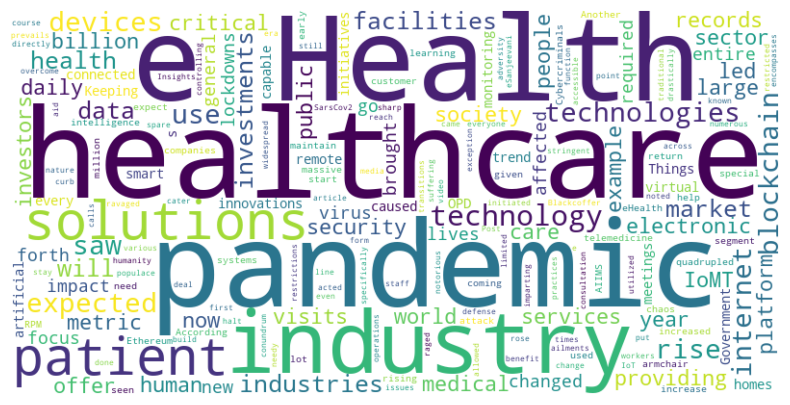

In [9]:
def generate_wordcloud(file_name):
    with open(file_name, 'r', encoding='utf-8') as file:
        text = file.read()

    # Generate WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

generate_wordcloud('Articles/2345.txt')

# Interpretation
>A positive polarity indicates a positive sentiment.<br>
>A negative polarity indicates a negative sentiment.<br>
>0 polarity indeicates a neutral sentiment.<br>
>The subjectivity score can give an idea of how subjective or objective the text is.